# 🎵 스포티파이 트랙 분석

Modeling

> EPOCH 3RD 한우림

> 2025.09.13. Sat

1. 주제: **노래 특성을 통한 곡 분류**

> 목표: 어떤 특성을 가진 음악이 사람들에게 인기가 많은지 파악하기

2. 분석 목적
- 인기도 예측 요인 식별: 어떤 음악적 특성들이 곡의 인기도를 결정하는 데 가장 중요한 역할을 하는지 분석
- 모델 구축 및 평가: 데이터를 활용하여 실제 예측 모델을 만들고, 이 모델의 성능을 객관적으로 평가

3. 기대 인사이트
- 주요 예측 변수: `popularity`를 예측하는 데 가장 큰 영향을 미치는 오디오 피처들을 순서대로 나열
- 장르별 인기도 차이: 특정 장르가 다른 장르에 비해 높은 인기를 얻는 경향이 있는지 파악

4. 분석 방법
- EDA
- 데이터 전처리: 결측치, 이상치, Log-Transformation, 스케일링
- 피처 엔지니어링: 어떤 피처를 예측 모델에 포함시킬지 선택
- 모델링 & 모델 선택
- 성능 평가
- 하이퍼파라미터 튜닝
- Feature Importance

## 라이브러리 및 데이터 불러오기, 확인

In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [5]:
df = pd.read_csv('dataset.csv', index_col=0)

In [6]:
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

- 114,000개의 로우, 20개의 컬럼
- `artists`, `album_name`, `track_name`에 각 1개씩 결측치 존재

1. object (5): `track_id`, `artists`, `album_name`, `track_name`, `track_genre`
    > 트랙에 대한 기본적인 정보
2. int/float (14): `popularity`, `duration_ms`, `dancability`, `energy`, `key`, `loudness`, `mode`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`, `time_signauture`
    > 트랙의 오디오 피처
3. bool (1): `explicit`
    > 트랙 가사의 explicit 포함 여부

1. `track_id`: 곡의 고유 ID
2. `artists`: 아티스트 이름; 여러 명일 경우 세미콜론(;)으로 구분
3. `album_name`: 곡이 수록된 앨범 이름
4. `track_name`: 곡 이름
5. `popularity`: 0부터 100까지의 인기도 점수; 높을수록 인기가 많음
6. `duration_ms`: 곡의 길이(밀리초)
7. `explicit`: 선정적인 가사 유무 (True/False)
8. `danceability`: 0.0에서 1.0까지의 댄스 적합성
9. `energy`: 0.0에서 1.0까지의 에너지 및 강도
10. `key`: 곡의 키; 숫자로 표현됨
11. `loudness`: 곡의 전체적인 음량(데시벨)
12. `mode`: 곡의 장조(1) 또는 단조(0) 여부
13. `speechiness`: 0.0에서 1.0까지의 곡 내 음성 비중
14. `acousticness`: 0.0에서 1.0까지의 어쿠스틱성
15. `instrumentalness`: 0.0에서 1.0까지의 보컬 부재 여부
16. `liveness`: 0.0에서 1.0까지의 라이브 공연 가능성
17. `valence`: 0.0에서 1.0까지의 음악적 긍정성
18. `tempo`: 곡의 빠르기(BPM)
19. `time_signature`: 3/4, 4/4와 같은 박자
20. `track_genre`: 곡의 장르

## Feature Selection

### `track_genre` 범주화

In [8]:
df = pd.read_csv('preprocessed_df.csv')
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [9]:
df['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [10]:
genre_to_category = {
    # Pop & Mainstream
    'pop': 'Pop & Mainstream',
    'power-pop': 'Pop & Mainstream',
    'indie-pop': 'Pop & Mainstream',
    'synth-pop': 'Pop & Mainstream',
    'dance': 'Pop & Mainstream',
    'dancehall': 'Pop & Mainstream',
    'disco': 'Pop & Mainstream',
    'club': 'Pop & Mainstream',
    'party': 'Pop & Mainstream',
    'pop-film': 'Pop & Mainstream',
    'mandopop': 'Pop & Mainstream',
    'cantopop': 'Pop & Mainstream',
    'latino': 'Pop & Mainstream',
    'mpb': 'Pop & Mainstream',
    'romance': 'Pop & Mainstream',

    # Asian Pop
    'k-pop': 'Asian Pop',
    'j-pop': 'Asian Pop',
    'j-rock': 'Asian Pop',
    'j-idol': 'Asian Pop',
    'j-dance': 'Asian Pop',
    'anime': 'Asian Pop',

    # Rock & Alternative
    'rock': 'Rock & Alternative',
    'alt-rock': 'Rock & Alternative',
    'indie': 'Rock & Alternative',
    'punk': 'Rock & Alternative',
    'punk-rock': 'Rock & Alternative',
    'grunge': 'Rock & Alternative',
    'hard-rock': 'Rock & Alternative',
    'rock-n-roll': 'Rock & Alternative',
    'rockabilly': 'Rock & Alternative',
    'psych-rock': 'Rock & Alternative',
    'emo': 'Rock & Alternative',
    'alternative': 'Rock & Alternative',
    'singer-songwriter': 'Rock & Alternative',
    'songwriter': 'Rock & Alternative',
    'guitar': 'Rock & Alternative',
    'garage': 'Rock & Alternative',

    # Metal & Hardcore
    'metal': 'Metal & Hardcore',
    'heavy-metal': 'Metal & Hardcore',
    'black-metal': 'Metal & Hardcore',
    'death-metal': 'Metal & Hardcore',
    'grindcore': 'Metal & Hardcore',
    'metalcore': 'Metal & Hardcore',
    'hardcore': 'Metal & Hardcore',
    'goth': 'Metal & Hardcore',
    'industrial': 'Metal & Hardcore',

    # Electronic & Dance & EDM
    'electronic': 'Electronic & Dance & EDM',
    'edm': 'Electronic & Dance & EDM',
    'house': 'Electronic & Dance & EDM',
    'deep-house': 'Electronic & Dance & EDM',
    'progressive-house': 'Electronic & Dance & EDM',
    'minimal-techno': 'Electronic & Dance & EDM',
    'techno': 'Electronic & Dance & EDM',
    'trance': 'Electronic & Dance & EDM',
    'idm': 'Electronic & Dance & EDM',
    'dubstep': 'Electronic & Dance & EDM',
    'drum-and-bass': 'Electronic & Dance & EDM',
    'breakbeat': 'Electronic & Dance & EDM',
    'electro': 'Electronic & Dance & EDM',
    'detroit-techno': 'Electronic & Dance & EDM',
    'chicago-house': 'Electronic & Dance & EDM',
    'trip-hop': 'Electronic & Dance & EDM',

    # Hip-Hop & R&B & Funk & Soul
    'hip-hop': 'Hip-Hop & R&B & Funk & Soul',
    'r-n-b': 'Hip-Hop & R&B & Funk & Soul',
    'soul': 'Hip-Hop & R&B & Funk & Soul',
    'funk': 'Hip-Hop & R&B & Funk & Soul',
    'groove': 'Hip-Hop & R&B & Funk & Soul',

    # Jazz & Blues
    'jazz': 'Jazz & Blues',
    'blues': 'Jazz & Blues',
    'bluegrass': 'Jazz & Blues',
    'gospel': 'Jazz & Blues',
    'ska': 'Jazz & Blues',

    # Classical & Traditional
    'classical': 'Classical & Traditional',
    'opera': 'Classical & Traditional',
    'piano': 'Classical & Traditional',
    'acoustic': 'Classical & Traditional',
    'study': 'Classical & Traditional',
    'sleep': 'Classical & Traditional',
    'new-age': 'Classical & Traditional',
    'ambient': 'Classical & Traditional',
    'country': 'Classical & Traditional',
    'folk': 'Classical & Traditional',
    'honky-tonk': 'Classical & Traditional',
    'chill': 'Classical & Traditional',

    # World & Regional Music
    'latin': 'World & Regional Music',
    'salsa': 'World & Regional Music',
    'samba': 'World & Regional Music',
    'tango': 'World & Regional Music',
    'forro': 'World & Regional Music',
    'pagode': 'World & Regional Music',
    'sertanejo': 'World & Regional Music',
    'brazil': 'World & Regional Music',
    'spanish': 'World & Regional Music',
    'french': 'World & Regional Music',
    'german': 'World & Regional Music',
    'indian': 'World & Regional Music',
    'iranian': 'World & Regional Music',
    'turkish': 'World & Regional Music',
    'malay': 'World & Regional Music',
    'swedish': 'World & Regional Music',
    'world-music': 'World & Regional Music',
    'afrobeat': 'World & Regional Music',
    'reggae': 'World & Regional Music',
    'reggaeton': 'World & Regional Music',

    # Children & Entertainment
    'children': 'Children & Entertainment',
    'kids': 'Children & Entertainment',
    'disney': 'Children & Entertainment',
    'comedy': 'Children & Entertainment',
    'show-tunes': 'Children & Entertainment',
    'happy': 'Children & Entertainment',
    'sad': 'Children & Entertainment'
}


In [11]:
df['music_category'] = df['track_genre'].apply(lambda x: genre_to_category.get(x, 'Others'))

df['music_category'].value_counts()

music_category
World & Regional Music         19929
Rock & Alternative             15985
Electronic & Dance & EDM       15969
Pop & Mainstream               14837
Classical & Traditional        11893
Metal & Hardcore                8988
Children & Entertainment        6982
Asian Pop                       5987
Jazz & Blues                    4994
Hip-Hop & R&B & Funk & Soul     4988
Others                          2997
Name: count, dtype: int64

### 두 가지 방법

선정한 피처
1) 장르 포함: `danceability`, `energy`, `speechiness`, `instrumentalness`, `liveness`, `valence`, `tempo`, `music_category`
    > 장르가 포함되면 모델의 성능이 어떨까? 정보가 중복되어서 오히려 낮아지려나?
2) 장르 제외: `danceability`, `energy`, `speechiness`, `instrumentalness`, `liveness`, `valence`, `tempo`

### Feature Selection (1)

In [12]:
# 예측에 사용할 피처(독립 변수) 리스트 정의
features_1 = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence',
             'tempo', 'music_category']

In [13]:
# 선택한 특성들만 포함하는 새로운 데이터프레임 생성
df_features_1 = df[features_1]

In [14]:
df_features_1.head(5)

,danceability,energy,speechiness,instrumentalness,liveness,valence,tempo,music_category
0,0.676,0.4610,0.1430,0.000001,0.3580,0.715,87.917,Classical & Traditional
1,0.420,0.1660,0.0763,0.000006,0.1010,0.267,77.489,Classical & Traditional
2,0.438,0.3590,0.0557,0.000000,0.1170,0.120,76.332,Classical & Traditional
3,0.266,0.0596,0.0363,0.000071,0.1320,0.143,181.740,Classical & Traditional
4,0.618,0.4430,0.0526,0.000000,0.0829,0.167,119.949,Classical & Traditional


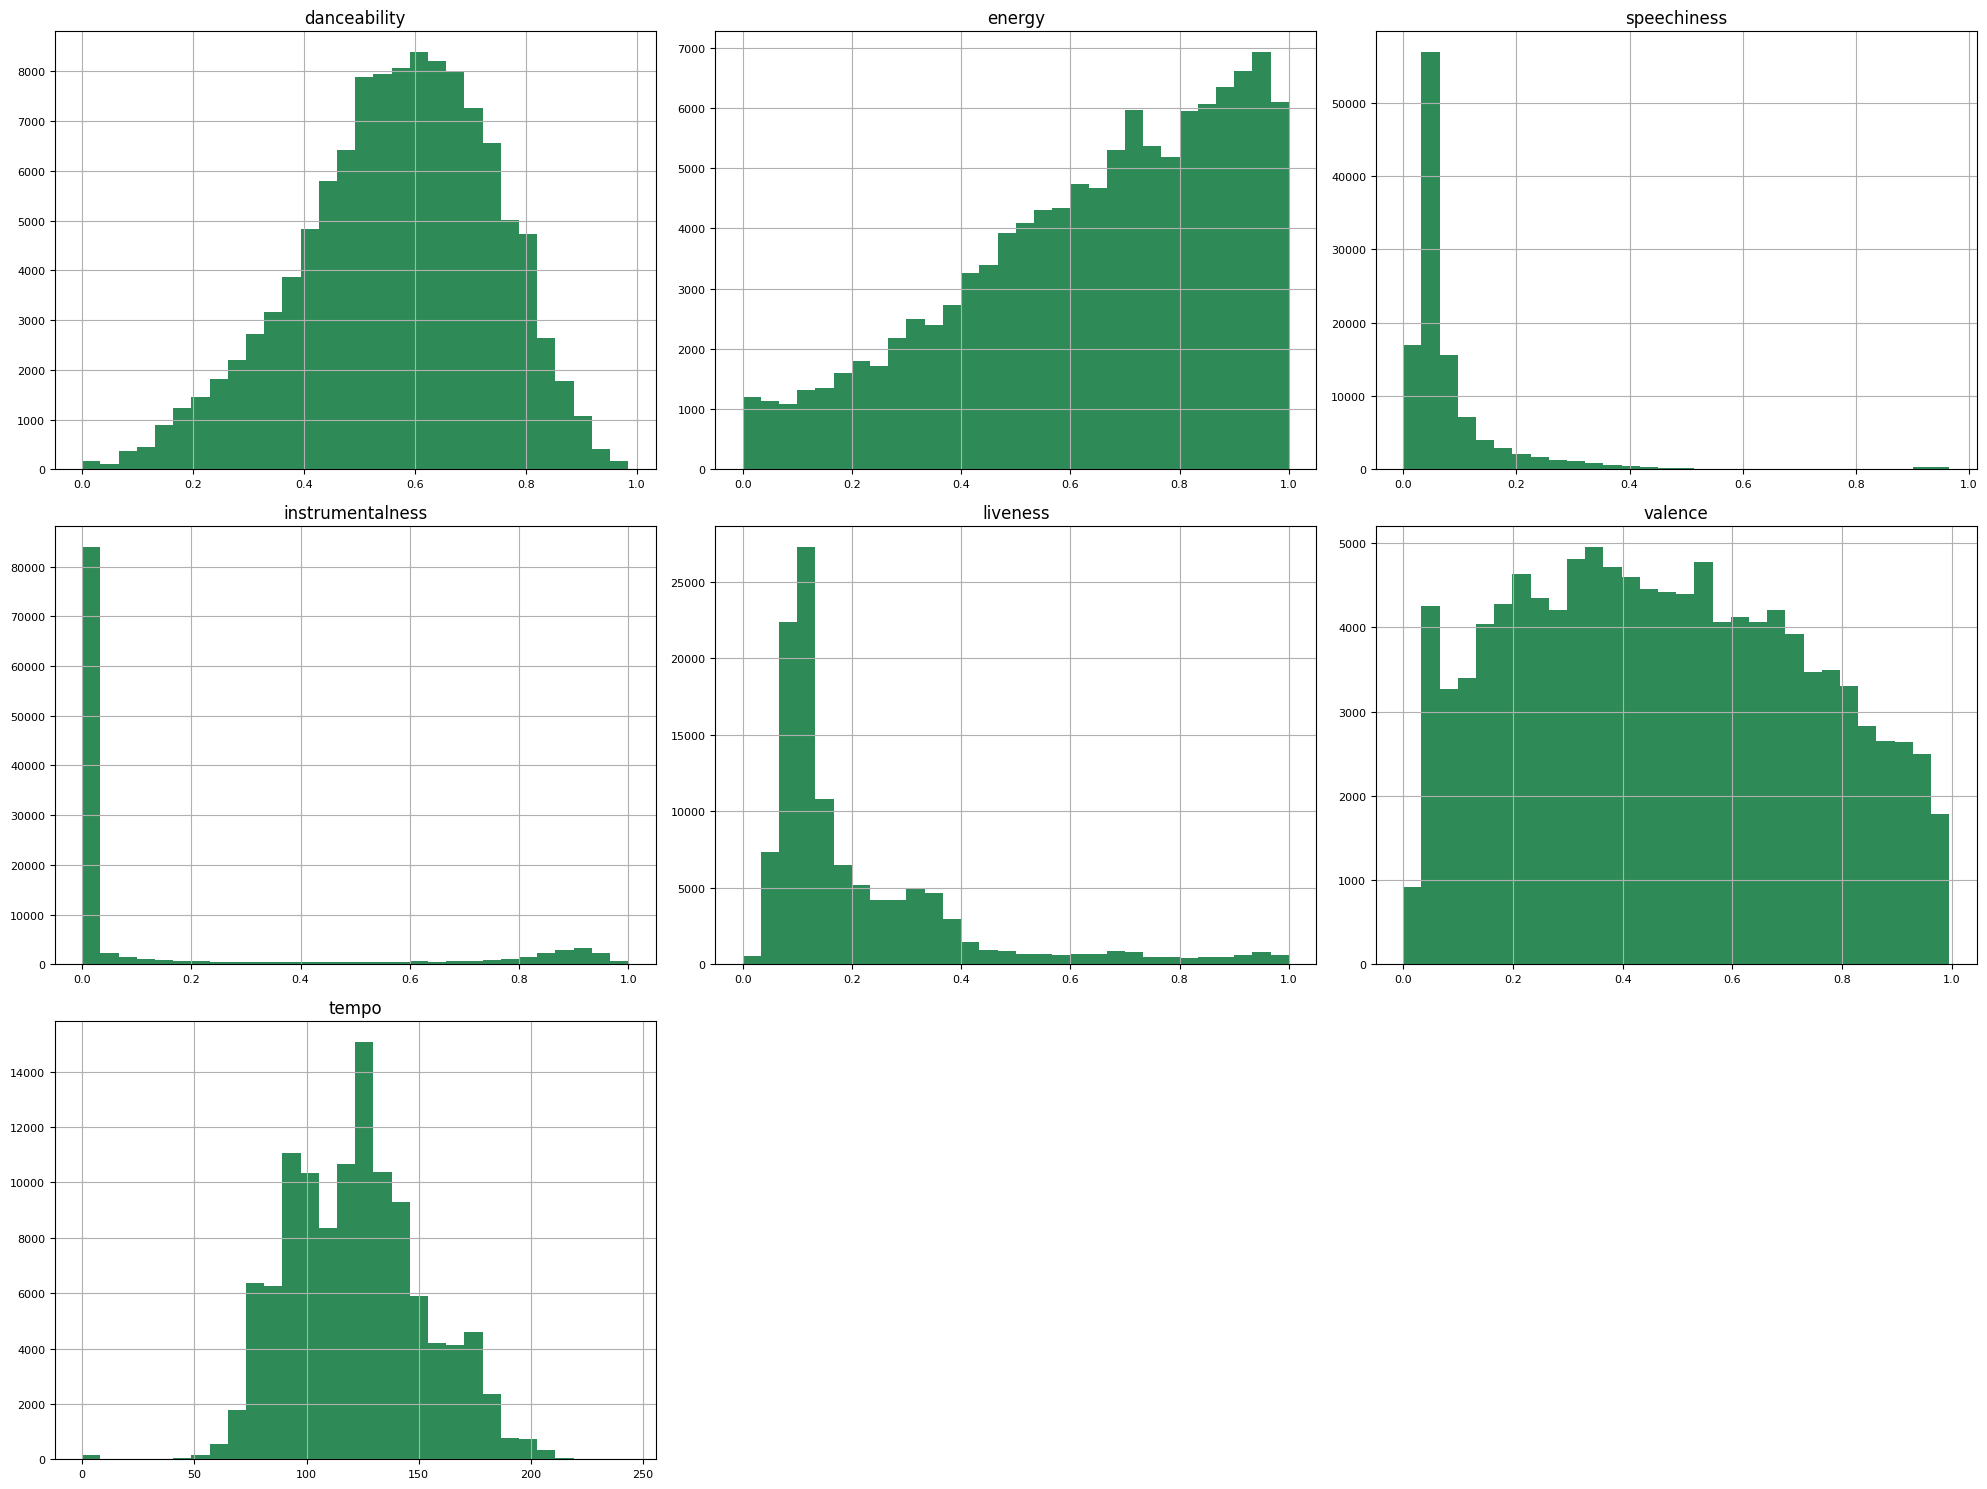

In [15]:
df_features_1.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8, color='seagreen')
plt.tight_layout()
plt.show()

- standard scaling: `tempo`
- log transform. -> standard scaling
    - `speechiness`, `instrumentalness`, `liveness`: 비대칭적 분포
- 이외에는 0과 1 사이의 범위를 가지며 치우쳐져 있지 않은 변수 -> No scaling

In [16]:
df_features_1

,danceability,energy,speechiness,instrumentalness,liveness,valence,tempo,music_category
0,0.676,0.4610,0.1430,0.000001,0.3580,0.7150,87.917,Classical & Traditional
1,0.420,0.1660,0.0763,0.000006,0.1010,0.2670,77.489,Classical & Traditional
2,0.438,0.3590,0.0557,0.000000,0.1170,0.1200,76.332,Classical & Traditional
3,0.266,0.0596,0.0363,0.000071,0.1320,0.1430,181.740,Classical & Traditional
4,0.618,0.4430,0.0526,0.000000,0.0829,0.1670,119.949,Classical & Traditional
...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0422,0.928000,0.0863,0.0339,125.995,World & Regional Music
113545,0.174,0.1170,0.0401,0.976000,0.1050,0.0350,85.239,World & Regional Music
113546,0.629,0.3290,0.0420,0.000000,0.0839,0.7430,132.378,World & Regional Music
113547,0.587,0.5060,0.0297,0.000000,0.2700,0.4130,135.960,World & Regional Music


In [17]:
# one-hot encoding
df_encoded = pd.get_dummies(df_features_1, columns=['music_category'], drop_first=True, dtype=int)
df_encoded.head()

,danceability,energy,speechiness,instrumentalness,liveness,valence,tempo,music_category_Children & Entertainment,music_category_Classical & Traditional,music_category_Electronic & Dance & EDM,music_category_Hip-Hop & R&B & Funk & Soul,music_category_Jazz & Blues,music_category_Metal & Hardcore,music_category_Others,music_category_Pop & Mainstream,music_category_Rock & Alternative,music_category_World & Regional Music
0,0.676,0.4610,0.1430,0.000001,0.3580,0.715,87.917,0,1,0,0,0,0,0,0,0,0
1,0.420,0.1660,0.0763,0.000006,0.1010,0.267,77.489,0,1,0,0,0,0,0,0,0,0
2,0.438,0.3590,0.0557,0.000000,0.1170,0.120,76.332,0,1,0,0,0,0,0,0,0,0
3,0.266,0.0596,0.0363,0.000071,0.1320,0.143,181.740,0,1,0,0,0,0,0,0,0,0
4,0.618,0.4430,0.0526,0.000000,0.0829,0.167,119.949,0,1,0,0,0,0,0,0,0,0


# Modeling

## Linear Regression

### 예상

오디오 피처들이 사실상 선형적인 관계로 곡의 인기도에 영향을 줄 것 같지 않음

> 선형 회귀 모델의 성능이 매우 낮게 나올 것으로 예상

> 전처리 연습 겸 선형 회귀를 위한 로그 변환, 스케일링을 해 보자

### Log-Transformation

 EDA 과정에서 오른쪽으로 꼬리가 긴 분포를 가진 변수를 확인할 수 있었음

> `speechiness`, `instrumentalness`, `liveness` 로그 변환

In [22]:
# 피처 엔지니어링을 위해 데이터 카피
df_featured = df_encoded.copy()

# 로그 변환을 적용할 피처
log_features = ['speechiness', 'instrumentalness', 'liveness']

In [23]:
# 로그 변환
for feature in log_features:
    df_featured[f'{feature}_log'] = np.log1p(df_featured[feature])
    df_featured = df_featured.drop(columns=[feature]) # 원본 피처 삭제

In [24]:
df_featured

,danceability,energy,valence,tempo,music_category_Children & Entertainment,music_category_Classical & Traditional,music_category_Electronic & Dance & EDM,music_category_Hip-Hop & R&B & Funk & Soul,music_category_Jazz & Blues,music_category_Metal & Hardcore,music_category_Others,music_category_Pop & Mainstream,music_category_Rock & Alternative,music_category_World & Regional Music,speechiness_log,instrumentalness_log,liveness_log
0,0.676,0.4610,0.7150,87.917,0,1,0,0,0,0,0,0,0,0,0.133656,0.000001,0.306013
1,0.420,0.1660,0.2670,77.489,0,1,0,0,0,0,0,0,0,0,0.073529,0.000006,0.096219
2,0.438,0.3590,0.1200,76.332,0,1,0,0,0,0,0,0,0,0,0.054204,0.000000,0.110647
3,0.266,0.0596,0.1430,181.740,0,1,0,0,0,0,0,0,0,0,0.035657,0.000071,0.123986
4,0.618,0.4430,0.1670,119.949,0,1,0,0,0,0,0,0,0,0,0.051263,0.000000,0.079643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0339,125.995,0,0,0,0,0,0,0,0,0,1,0.041334,0.656483,0.082777
113545,0.174,0.1170,0.0350,85.239,0,0,0,0,0,0,0,0,0,1,0.039317,0.681075,0.099845
113546,0.629,0.3290,0.7430,132.378,0,0,0,0,0,0,0,0,0,1,0.041142,0.000000,0.080566
113547,0.587,0.5060,0.4130,135.960,0,0,0,0,0,0,0,0,0,1,0.029267,0.000000,0.239017


### Scaling

 선형 회귀 모델을 위한 스케일링 과정

In [25]:
scaling_features = ['speechiness_log', 'instrumentalness_log', 'liveness_log','tempo']

In [26]:
df_featured

,danceability,energy,valence,tempo,music_category_Children & Entertainment,music_category_Classical & Traditional,music_category_Electronic & Dance & EDM,music_category_Hip-Hop & R&B & Funk & Soul,music_category_Jazz & Blues,music_category_Metal & Hardcore,music_category_Others,music_category_Pop & Mainstream,music_category_Rock & Alternative,music_category_World & Regional Music,speechiness_log,instrumentalness_log,liveness_log
0,0.676,0.4610,0.7150,87.917,0,1,0,0,0,0,0,0,0,0,0.133656,0.000001,0.306013
1,0.420,0.1660,0.2670,77.489,0,1,0,0,0,0,0,0,0,0,0.073529,0.000006,0.096219
2,0.438,0.3590,0.1200,76.332,0,1,0,0,0,0,0,0,0,0,0.054204,0.000000,0.110647
3,0.266,0.0596,0.1430,181.740,0,1,0,0,0,0,0,0,0,0,0.035657,0.000071,0.123986
4,0.618,0.4430,0.1670,119.949,0,1,0,0,0,0,0,0,0,0,0.051263,0.000000,0.079643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0339,125.995,0,0,0,0,0,0,0,0,0,1,0.041334,0.656483,0.082777
113545,0.174,0.1170,0.0350,85.239,0,0,0,0,0,0,0,0,0,1,0.039317,0.681075,0.099845
113546,0.629,0.3290,0.7430,132.378,0,0,0,0,0,0,0,0,0,1,0.041142,0.000000,0.080566
113547,0.587,0.5060,0.4130,135.960,0,0,0,0,0,0,0,0,0,1,0.029267,0.000000,0.239017


In [27]:
from sklearn.preprocessing import StandardScaler

# StandardScaler 객체 생성
scaler = StandardScaler()

# 선택한 피처들에 대해 정규화
scaled_features = scaler.fit_transform(df_featured[scaling_features])

# 정규화된 데이터를 데이터프레임으로 변환
df_scaled = pd.DataFrame(scaled_features, columns=scaling_features)

# 정규화된 데이터 상위 5개 행 확인
print(df_scaled.head())

   speechiness_log  instrumentalness_log  liveness_log     tempo
0         0.681490             -0.517925      0.886884 -1.142994
1        -0.048194             -0.517905     -0.628200 -1.490909
2        -0.282719             -0.517930     -0.524007 -1.529510
3        -0.507804             -0.517615     -0.427672  1.987275
4        -0.318407             -0.517930     -0.747909 -0.074292


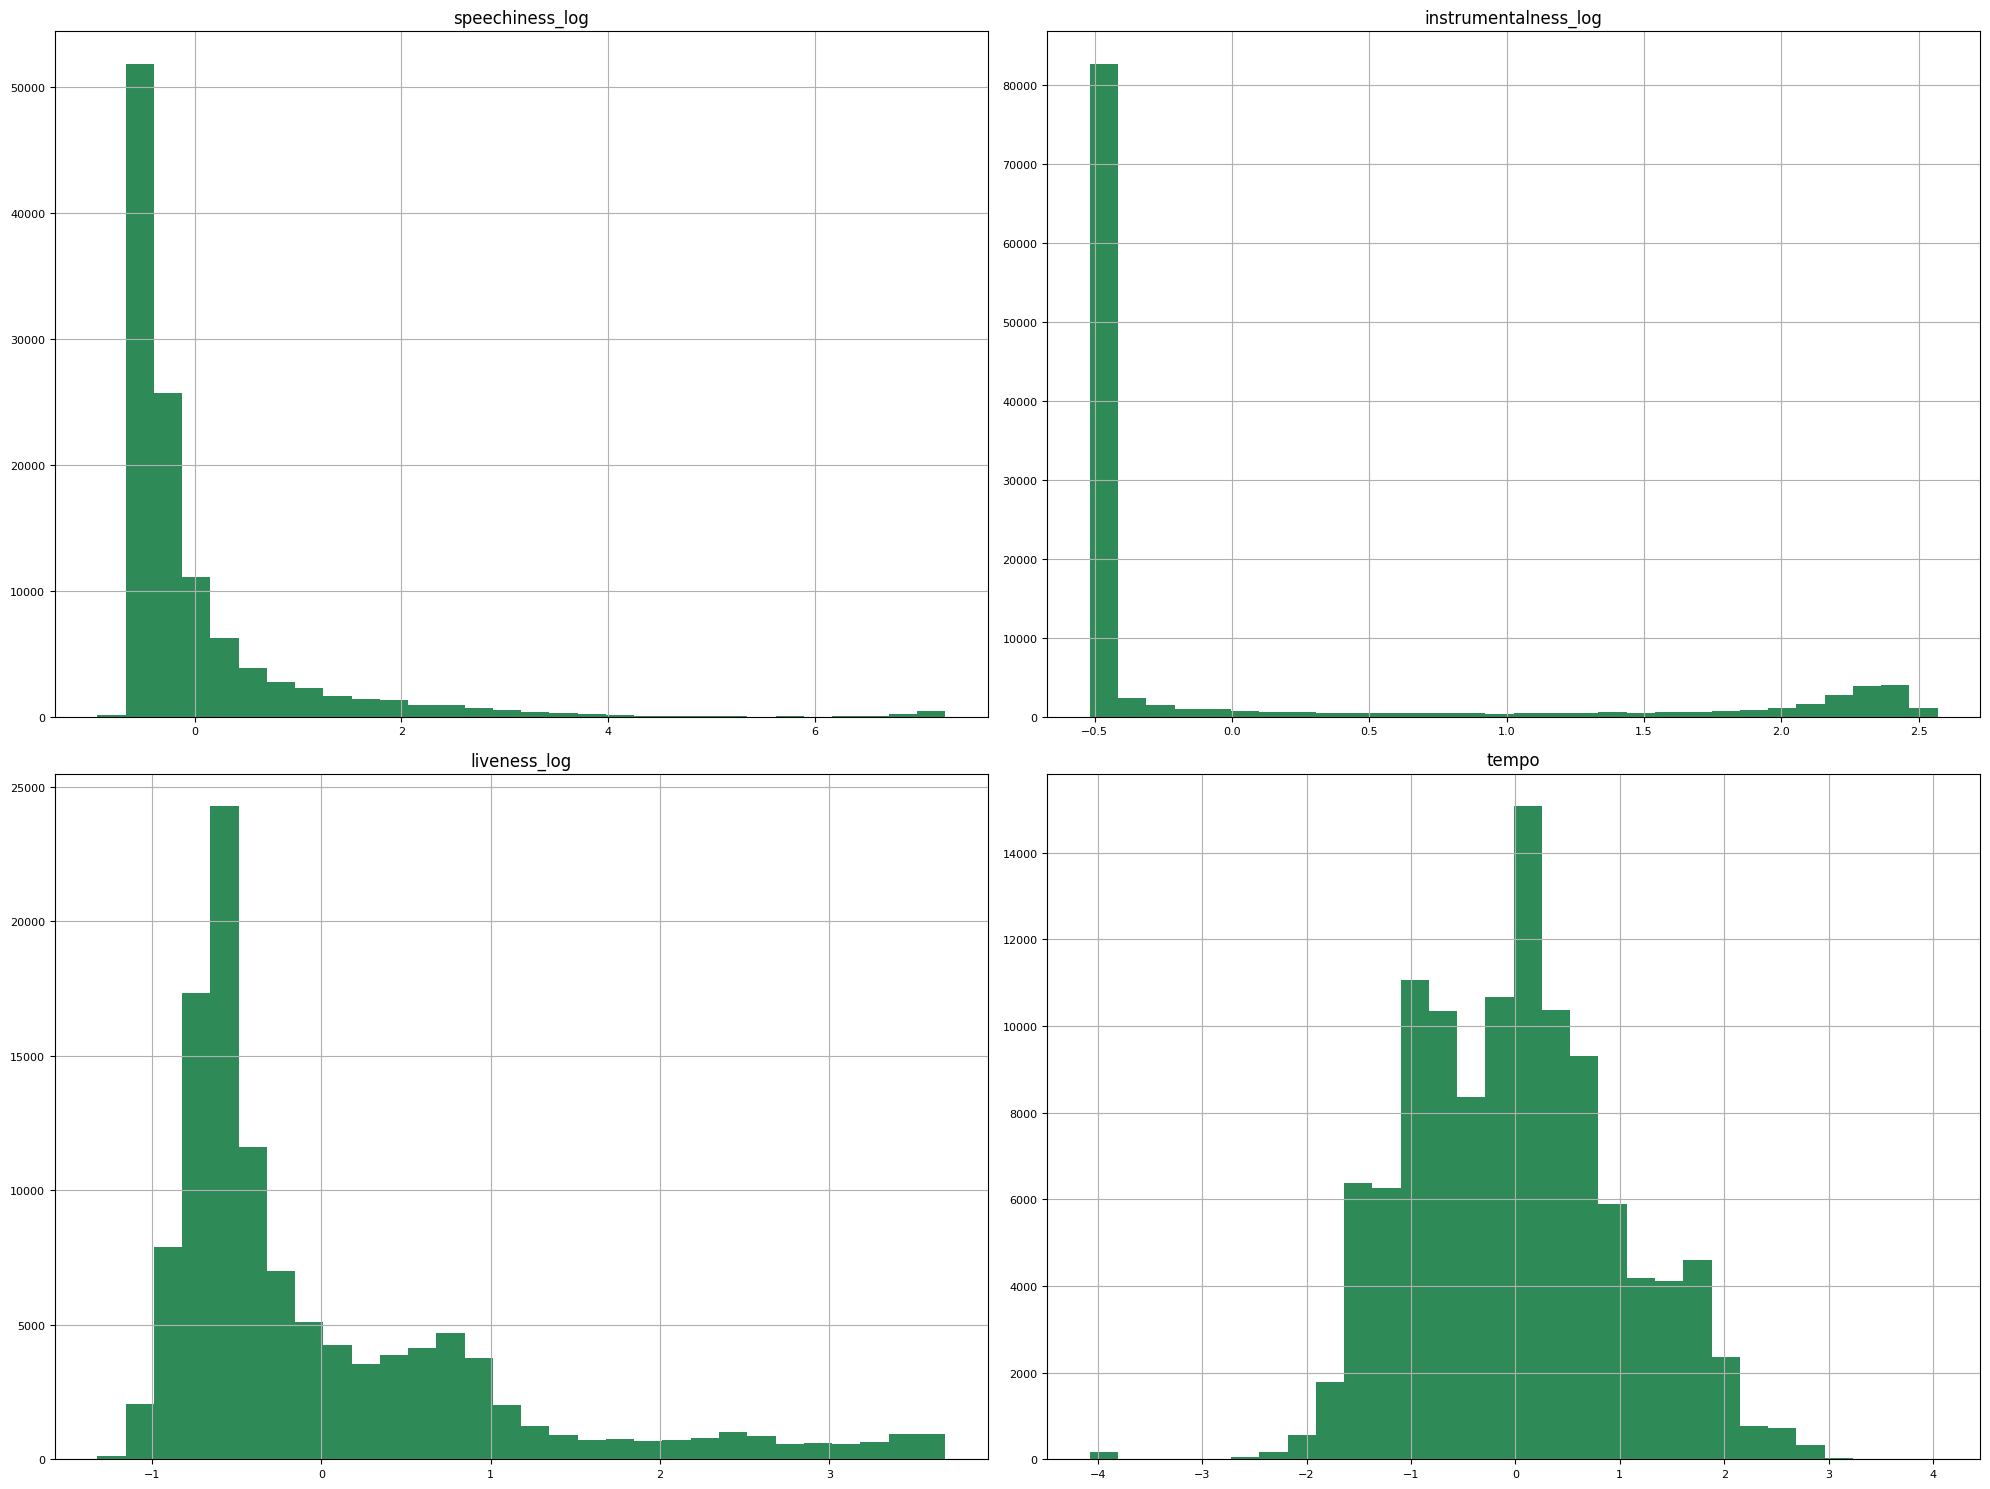

In [28]:
df_scaled.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8, color='seagreen')
plt.tight_layout()
plt.show()

In [29]:
to_drop_features = ['speechiness', 'instrumentalness', 'liveness', 'tempo']

In [30]:
df_linear = df_encoded.copy()
df_linear = df_linear.drop(to_drop_features, axis=1)
df_linear = pd.concat([df_linear, df_scaled], axis=1)
df_linear

,danceability,energy,valence,music_category_Children & Entertainment,music_category_Classical & Traditional,music_category_Electronic & Dance & EDM,music_category_Hip-Hop & R&B & Funk & Soul,music_category_Jazz & Blues,music_category_Metal & Hardcore,music_category_Others,music_category_Pop & Mainstream,music_category_Rock & Alternative,music_category_World & Regional Music,speechiness_log,instrumentalness_log,liveness_log,tempo
0,0.676,0.4610,0.7150,0,1,0,0,0,0,0,0,0,0,0.681490,-0.517925,0.886884,-1.142994
1,0.420,0.1660,0.2670,0,1,0,0,0,0,0,0,0,0,-0.048194,-0.517905,-0.628200,-1.490909
2,0.438,0.3590,0.1200,0,1,0,0,0,0,0,0,0,0,-0.282719,-0.517930,-0.524007,-1.529510
3,0.266,0.0596,0.1430,0,1,0,0,0,0,0,0,0,0,-0.507804,-0.517615,-0.427672,1.987275
4,0.618,0.4430,0.1670,0,1,0,0,0,0,0,0,0,0,-0.318407,-0.517930,-0.747909,-0.074292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0339,0,0,0,0,0,0,0,0,0,1,-0.438907,2.405398,-0.725271,0.127424
113545,0.174,0.1170,0.0350,0,0,0,0,0,0,0,0,0,1,-0.463385,2.514904,-0.602010,-1.232341
113546,0.629,0.3290,0.7430,0,0,0,0,0,0,0,0,0,1,-0.441237,-0.517930,-0.741244,0.340384
113547,0.587,0.5060,0.4130,0,0,0,0,0,0,0,0,0,1,-0.585341,-0.517930,0.403054,0.459892


### 스케일링 후 선형 회귀

In [31]:
df_features_X = df_linear.copy()
df_features_y = df['popularity']

In [32]:
df_linear

,danceability,energy,valence,music_category_Children & Entertainment,music_category_Classical & Traditional,music_category_Electronic & Dance & EDM,music_category_Hip-Hop & R&B & Funk & Soul,music_category_Jazz & Blues,music_category_Metal & Hardcore,music_category_Others,music_category_Pop & Mainstream,music_category_Rock & Alternative,music_category_World & Regional Music,speechiness_log,instrumentalness_log,liveness_log,tempo
0,0.676,0.4610,0.7150,0,1,0,0,0,0,0,0,0,0,0.681490,-0.517925,0.886884,-1.142994
1,0.420,0.1660,0.2670,0,1,0,0,0,0,0,0,0,0,-0.048194,-0.517905,-0.628200,-1.490909
2,0.438,0.3590,0.1200,0,1,0,0,0,0,0,0,0,0,-0.282719,-0.517930,-0.524007,-1.529510
3,0.266,0.0596,0.1430,0,1,0,0,0,0,0,0,0,0,-0.507804,-0.517615,-0.427672,1.987275
4,0.618,0.4430,0.1670,0,1,0,0,0,0,0,0,0,0,-0.318407,-0.517930,-0.747909,-0.074292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113544,0.172,0.2350,0.0339,0,0,0,0,0,0,0,0,0,1,-0.438907,2.405398,-0.725271,0.127424
113545,0.174,0.1170,0.0350,0,0,0,0,0,0,0,0,0,1,-0.463385,2.514904,-0.602010,-1.232341
113546,0.629,0.3290,0.7430,0,0,0,0,0,0,0,0,0,1,-0.441237,-0.517930,-0.741244,0.340384
113547,0.587,0.5060,0.4130,0,0,0,0,0,0,0,0,0,1,-0.585341,-0.517930,0.403054,0.459892


In [33]:
X_train, X_test, y_train, y_test = train_test_split(df_features_X, df_features_y, test_size = 0.2, random_state=100)

# modeling and prediction
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
comparison = pd.DataFrame({'actual': y_test, 'pred': pred})
comparison

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

478.26044991400687

In [34]:
model.score(X_train, y_train)

0.033263309579544376

**0.0326** -> 예상대로 정말 낮은 선형회귀 성능...

## Random Forest의 Feature Importance 확인하기

In [37]:
df.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,instrumentalness,liveness,valence,tempo,time_signature,track_genre,tempo_medium,tempo_fast,tempo_very_fast,music_category
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,0.000001,0.3580,0.715,87.917,4,acoustic,False,False,False,Others
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,0.000006,0.1010,0.267,77.489,4,acoustic,False,False,False,Others
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,0.000000,0.1170,0.120,76.332,4,acoustic,False,False,False,Others
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,0.000071,0.1320,0.143,181.740,3,acoustic,False,False,True,Others
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,0.000000,0.0829,0.167,119.949,4,acoustic,True,False,False,Others


In [38]:
## 피처 셀렉션 수정하면서 모델링하는 코드

X = df_encoded.copy()
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [39]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [40]:
# 코드 수정 후
print(rmse)
print(r2)

16.090561978738098
0.48385350890626233


In [41]:
rf.feature_importances_

array([0.13939917, 0.1416885 , 0.13652339, 0.1016954 , 0.12331917,
       0.13548444, 0.14269659, 0.00674141, 0.00677593, 0.00899145,
       0.00808015, 0.00457345, 0.00525672, 0.00282735, 0.01079659,
       0.01210451, 0.01304578])

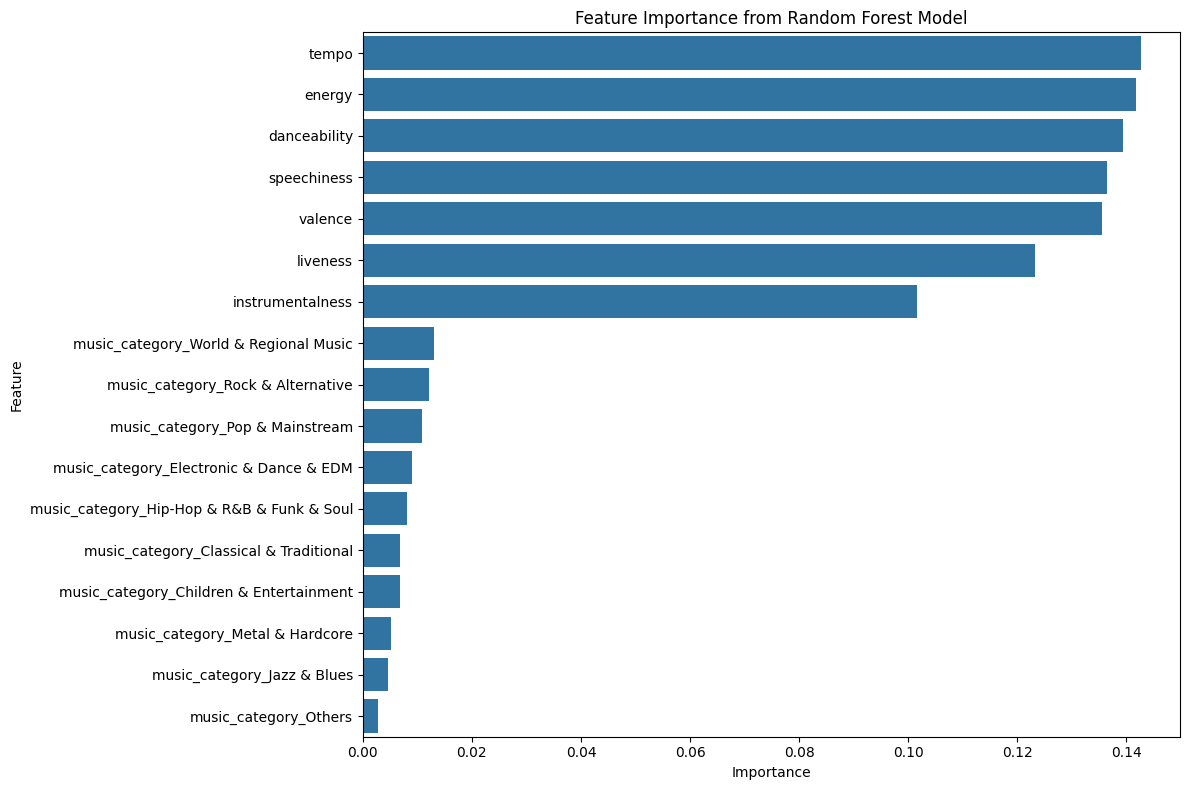

In [ ]:
# 피처 중요도 추출
feature_importances = rf.feature_importances_

# 피처 중요도를 DataFrame으로 정리 및 정렬
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

- `music_category`가 유의미하게 중요하지 않은 것을 확인함
- `tempo`, `energy`와 같은 오디오 변수들에 대해서는 상대적으로 높은 중요도를 보임


> 장르를 제외한 **Audio** 피쳐들에 대해서만 분석을 진행하자.

# Feature Selection (2)

In [43]:
# 예측에 사용할 피처(독립 변수) 리스트 정의
features_2 = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [44]:
# 선택한 특성들만 포함하는 새로운 데이터프레임 생성
df_features_2 = df[features_2]

In [45]:
df_features_2.head(5)

,danceability,energy,speechiness,instrumentalness,liveness,valence,tempo
0,0.676,0.4610,0.1430,0.000001,0.3580,0.715,87.917
1,0.420,0.1660,0.0763,0.000006,0.1010,0.267,77.489
2,0.438,0.3590,0.0557,0.000000,0.1170,0.120,76.332
3,0.266,0.0596,0.0363,0.000071,0.1320,0.143,181.740
4,0.618,0.4430,0.0526,0.000000,0.0829,0.167,119.949


모두 수치형 변수로, 트리 기반 모델을 사용할 것이므로 스케일링을 따로 진행하지 않을 것.

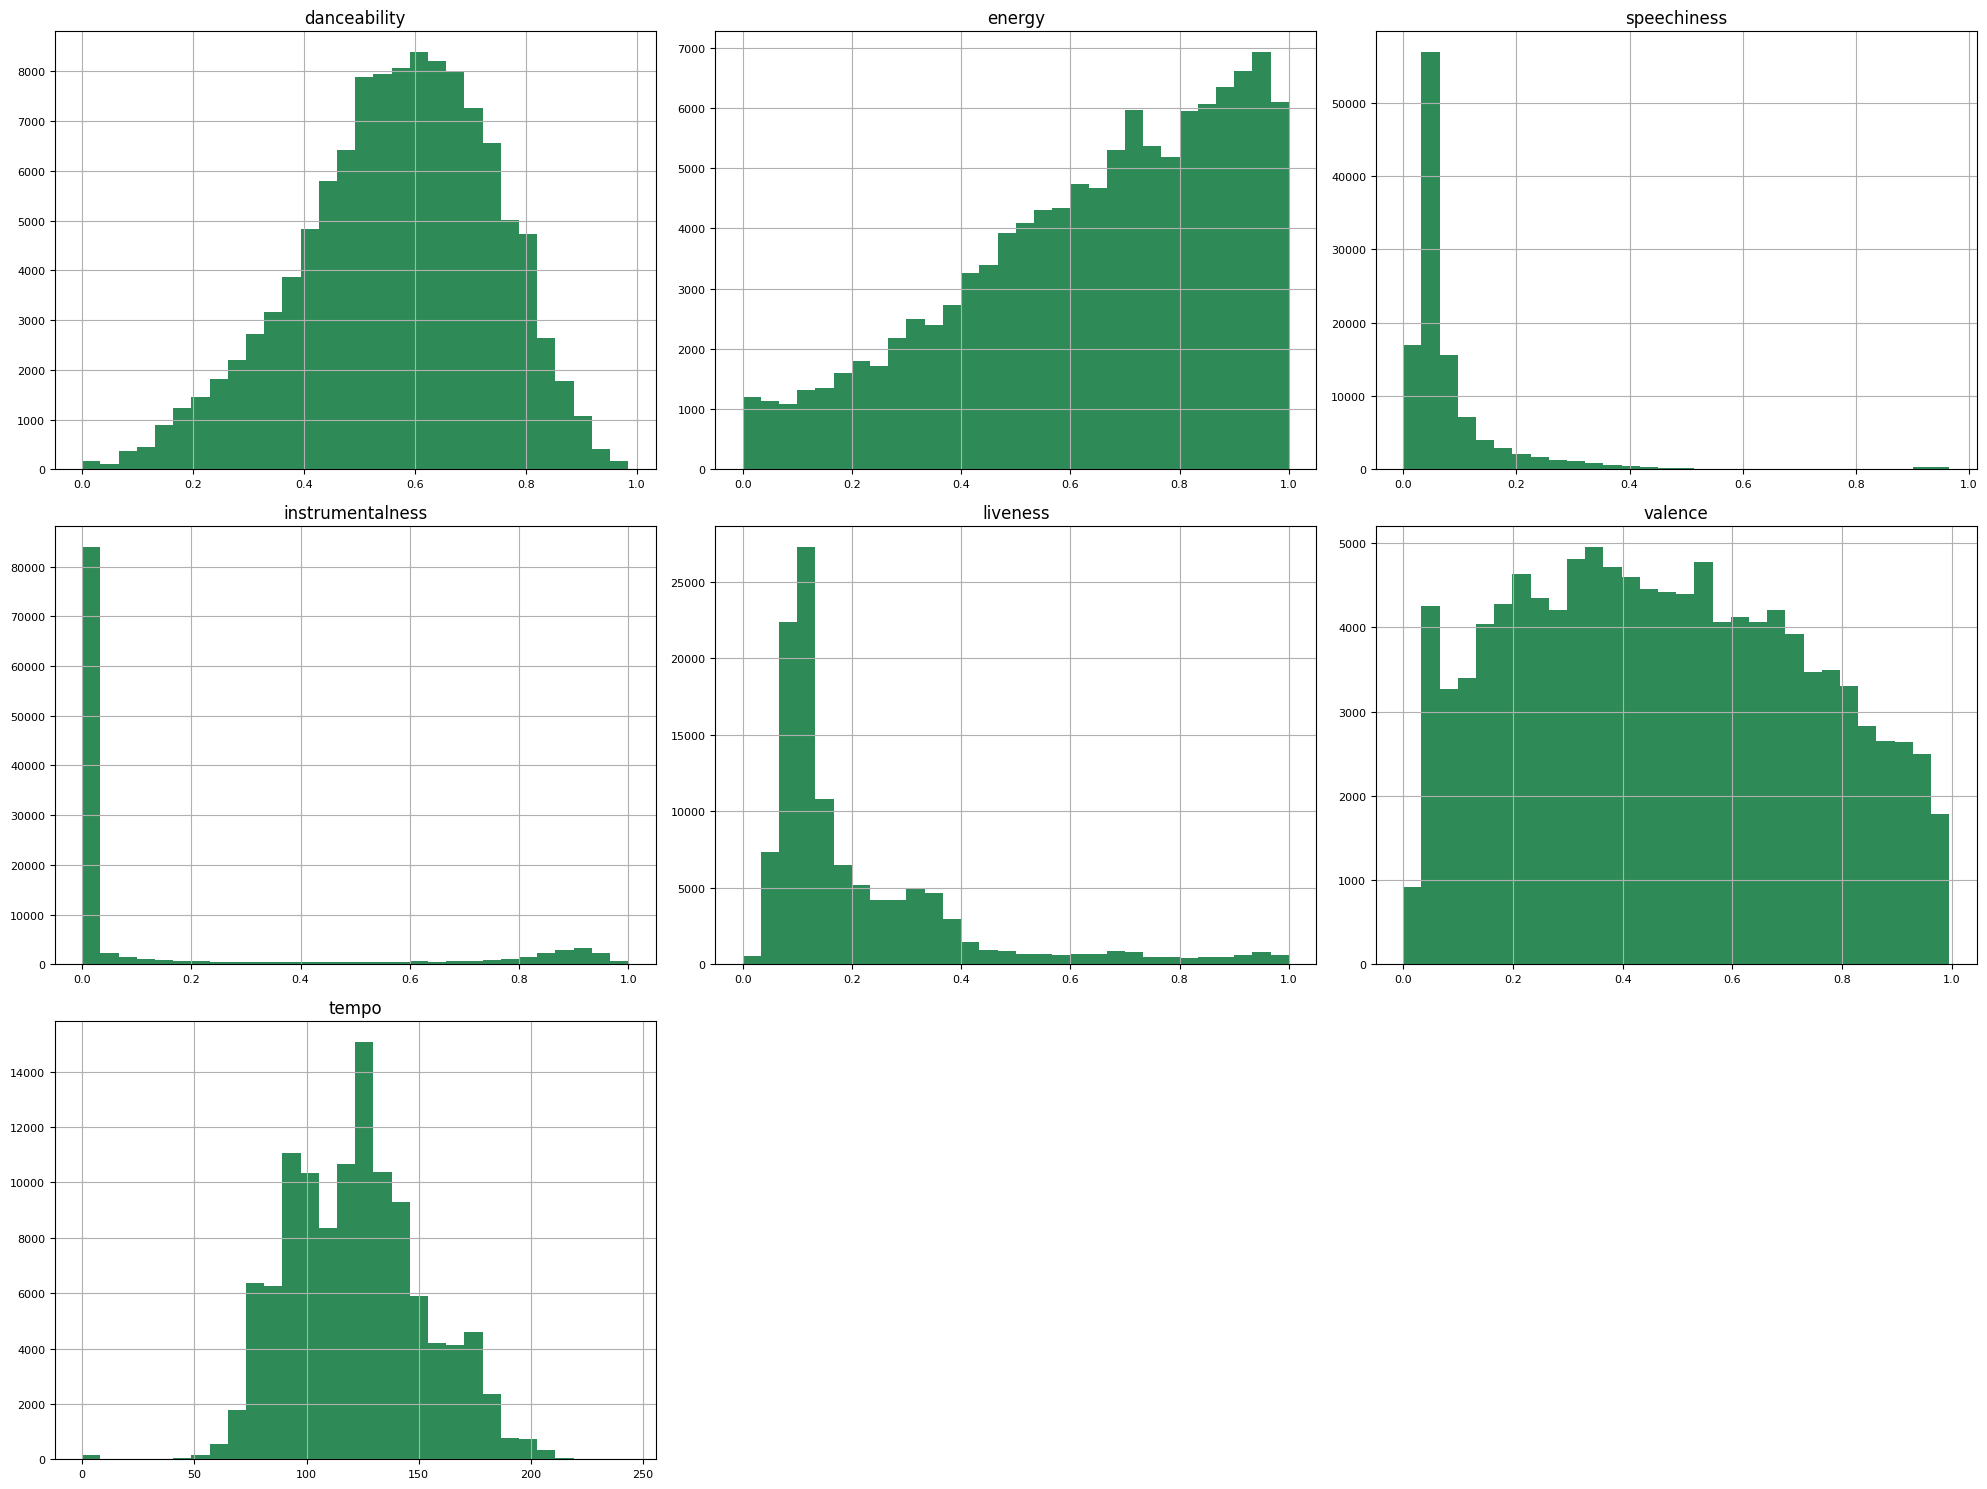

In [47]:
df_features_2.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8, color='seagreen')
plt.tight_layout()
plt.show()

In [49]:
df_features_2.to_csv('df_features_2.csv', index=False)

## Modeling

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


--- Linear Regression 모델 학습 시작 ---
RMSE: 22.1282, R2 Score: 0.0238

--- Ridge 모델 학습 시작 ---
RMSE: 22.1282, R2 Score: 0.0238

--- Lasso 모델 학습 시작 ---
RMSE: 22.3943, R2 Score: 0.0002

--- Random Forest 모델 학습 시작 ---
RMSE: 15.6017, R2 Score: 0.5147

--- Gradient Boosting 모델 학습 시작 ---
RMSE: 21.5580, R2 Score: 0.0735

--- XGBoost 모델 학습 시작 ---
RMSE: 19.7780, R2 Score: 0.2202

--- LightGBM 모델 학습 시작 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 90839, number of used features: 7
[LightGBM] [Info] Start training from score 33.339821
RMSE: 20.7137, R2 Score: 0.1446



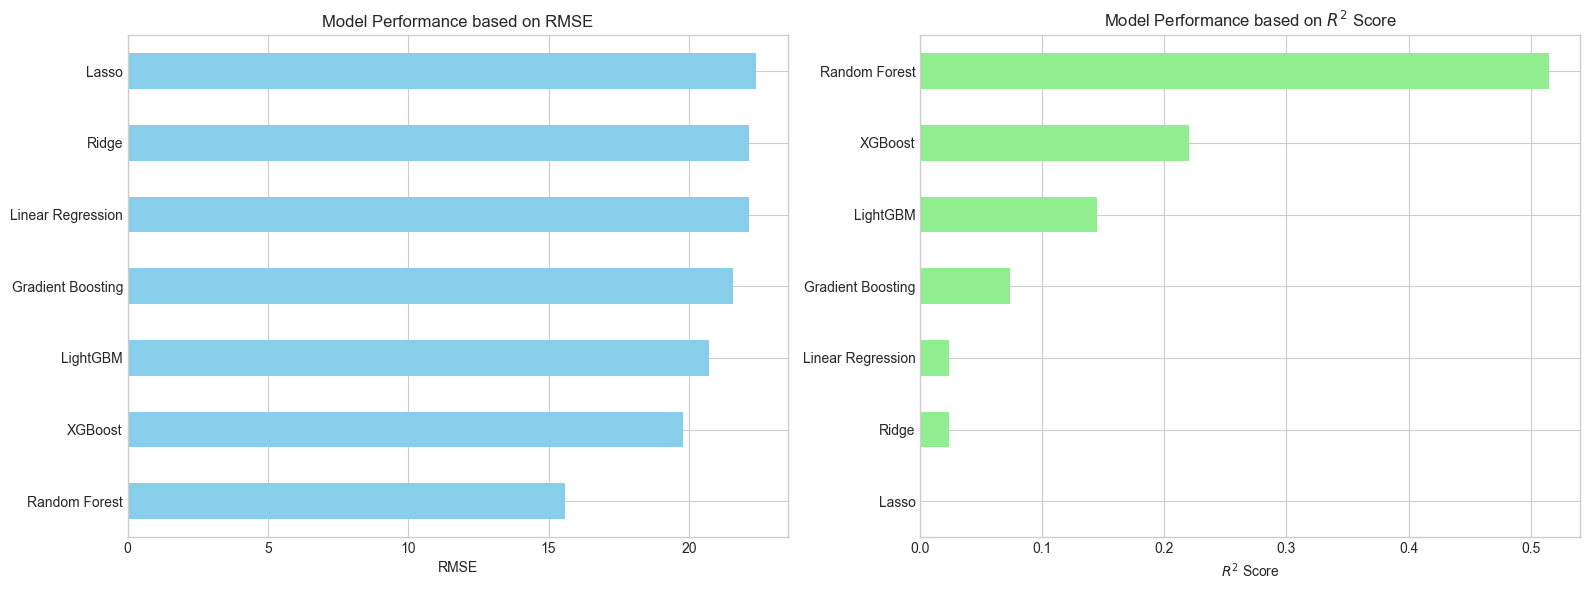

In [50]:
class MLPredictor:
    def __init__(self, models):
        self.models = models
        self.results = {}

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        for name, model in self.models.items():
            print(f"--- {name} 모델 학습 시작 ---")
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            self.results[name] = {'RMSE': rmse, 'R2_Score': r2}
            print(f"RMSE: {rmse:.4f}, R2 Score: {r2:.4f}\n")

    def visualize_results(self):
        results_df = pd.DataFrame(self.results).T
        
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # RMSE
        results_df['RMSE'].sort_values().plot(kind='barh', ax=axes[0], color='skyblue')
        axes[0].set_title('Model Performance based on RMSE')
        axes[0].set_xlabel('RMSE')
        
        # R2 Score
        results_df['R2_Score'].sort_values().plot(kind='barh', ax=axes[1], color='lightgreen')
        axes[1].set_title('Model Performance based on $R^2$ Score')
        axes[1].set_xlabel('$R^2$ Score')
        
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    df = pd.read_csv('df.csv')
    df_features_2 = pd.read_csv('df_features_2.csv')

    X = df_features_2.copy()
    y = df['popularity']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'LightGBM': LGBMRegressor(random_state=42)
    }

    predictor = MLPredictor(models)
    predictor.train_and_evaluate(X_train, X_test, y_train, y_test)
    predictor.visualize_results()

**Random Forest 모델 학습 결과**
RMSE: 15.6017, R2 Score: 0.5147

> 랜포 결정계수가 0.51로 가장 높고, XGBoost, LightGBM과 같은 부스팅 계열의 알고리즘 성능이 생각보다 많이 낮게 나왔다

> Linear/Ridge/Lasso 의 경우, 모델 학습 전에도 _오디오 피처가 곡의 인기도에 선형적으로 영향을 미치지는 않을 것_ 으로 예상했기 때문에, 예상과 같은 결과가 도출되긴 했으나 많이 낮은 R^2를 보여 주고 있다

> 랜포를 주 알고리즘으로 잡고, 다음에는 하이퍼파라미터 튜닝 과정을 통해 성능을 조금이나마 향상시켜 보자

In [60]:
X = df_features_2.copy()
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [61]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [62]:
print(rmse)
print(r2)

15.601730828597622
0.514738187554311


In [63]:
rf_model.feature_importances_

array([0.1503463 , 0.15091372, 0.14814735, 0.10750021, 0.13696124,
       0.1471311 , 0.15900008])

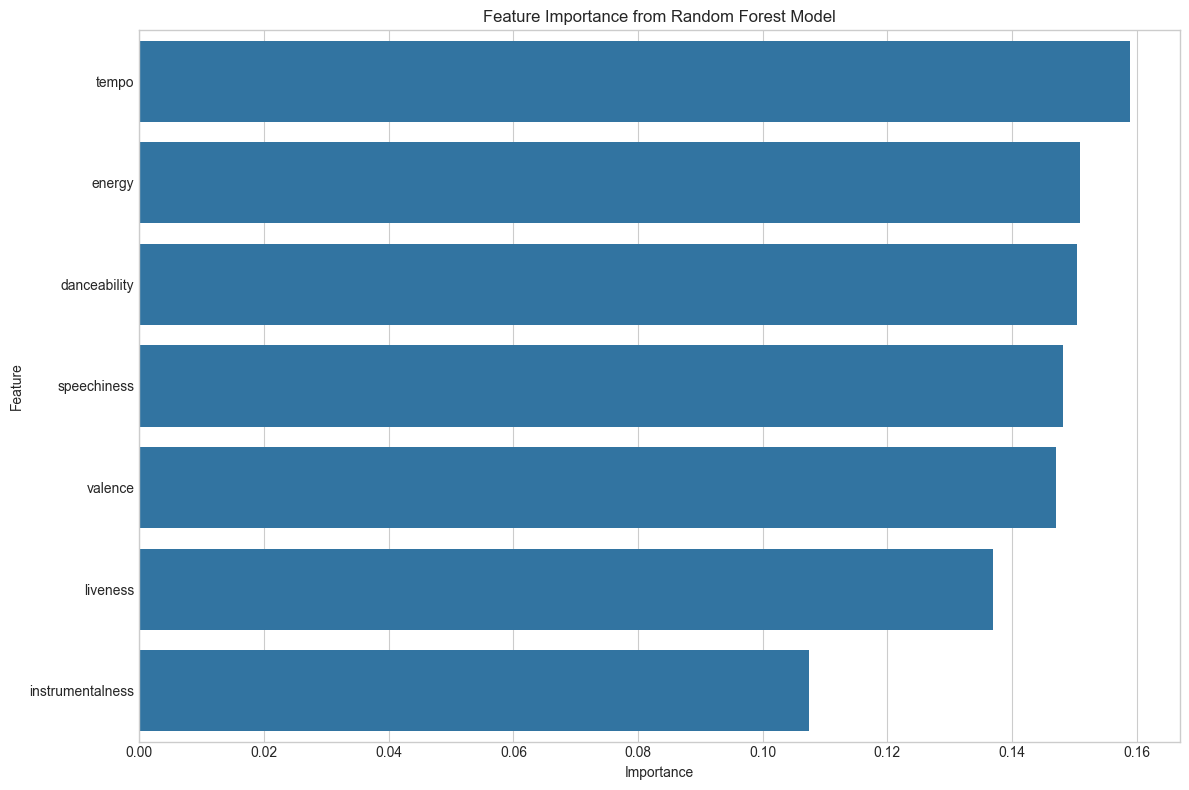

In [64]:
# 피처 중요도 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 DataFrame으로 정리 및 정렬
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
# 번외 - XGBoost 하이퍼파라미터 튜닝
# XGBoost 모델과 GridSearchCV 설정
xgb_model = XGBRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# GridSearchCV로 최적의 파라미터 찾기
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=xgb_param_grid, 
    cv=5, 
    scoring='r2', 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("XGBoost 최적 파라미터:", grid_search.best_params_)
print("XGBoost 최고 R2 점수:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost 최적 파라미터: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
XGBoost 최고 R2 점수: 0.2654894471168518


번외) XGBoost 하아피퍼라마티너 튜닝 후 모델 재학습 결과, 약 0.22의 R^2에서 약 0.27 정도로 소폭 상승함